In [6]:
import numpy
import pandas as pd
import requests
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import LSTM, Dense, Flatten, TimeDistributed, Conv1D, MaxPooling1D

ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:
# data preparation
def download_usd():
    url = 'http://infra.datos.gob.ar/catalog/sspm/dataset/168/distribution/168.1/download/datos-tipo-cambio-usd-futuro-dolar-frecuencia-diaria.csv'
    r = requests.get(url)
    with open('dolar.csv', 'wb') as f:
        f.write(r.content)

def split_sequence(sequence, n_steps):
    """
    split a univariate sequence into samples
    """
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return numpy.array(X), numpy.array(y)

# download most recent data from datos.gob.ar
# download_usd()

data = pd.read_csv("dolar.csv")
historic_data = data.tipo_cambio_a3500.values[-1000:]

# choose a number of time steps
n_steps = 4

# split into samples
X, y = split_sequence(historic_data, n_steps)

n_features = 1
n_seq = 2
n_steps = 2
n_epochs = 500
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))

In [ ]:
# model definition
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64,
                                 kernel_size=1,
                                 activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu')) # we do no normalization, so use relu
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [ ]:
# model training
model.fit(X, y, epochs=n_epochs, verbose=0)

In [ ]:
# predict dolar 🐬
predicted_values = []
last_predicted = data.tipo_cambio_a3500.values[-4:]
n_values_to_predict = 4

for x in range(n_values_to_predict):
    x_input = last_predicted.reshape((1, n_seq, n_steps, n_features))
    y = model.predict(x_input, verbose=0)
    y_predicted = y.flatten()[0]
    predicted_values.append(y_predicted)
    # calculate next batch of samples for prediction, 
    # including the last prediction we just did.
    last_predicted = last_predicted[1:]
    last_predicted = numpy.append(last_predicted, [y])
    
print("Predicted values: " + str(predicted_values))

Predicted values: [45.061512, 44.724457, 44.724457, 44.328255]


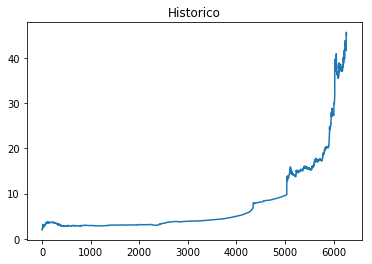

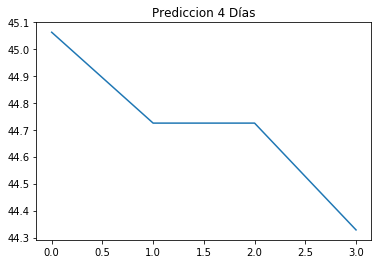

In [ ]:
from matplotlib import pyplot

pyplot.title("Historico")
pyplot.plot(data.tipo_cambio_a3500) 
pyplot.show()

pyplot.title("Prediccion " + str(n_values_to_predict) + " Días")
pyplot.plot(predicted_values) 
pyplot.show()